In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import csv

In [2]:
num_classes = 10
epochs = 50
latent_dim = 128

In [3]:
with open('../digits_train_prepr_revised.csv', newline='') as f: # Load dataset
    reader = csv.reader(f)
    train_x = [ [int(g) for g in image ] for image in list(reader) ] # Convert text to integers

In [4]:
with open('../digits_test_prepr_revised.csv', newline='') as f: # Load dataset
    reader = csv.reader(f)
    test_x = [ [float(g) for g in image ] for image in list(reader) ] # Convert text to integers

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
model3 = keras.models.load_model("../recognizer/model3")
model5 = keras.models.load_model("../recognizer/model5")
model7 = keras.models.load_model("../recognizer/model7")

model3PCA = keras.models.load_model("../recognizer PCA/model3")
model5PCA = keras.models.load_model("../recognizer PCA/model5")
model7PCA = keras.models.load_model("../recognizer PCA/model7")

discriminator = keras.models.load_model("../GAN/discriminator")
generator = keras.models.load_model("../GAN/generator")

In [7]:
def ensemblepredict(xset, mod3, mod5, mod7):
    preds3 = mod3.predict(xset)
    preds5 = mod5.predict(xset)
    preds7 = mod7.predict(xset)
    
    r = []
    for (x,y,z) in zip(preds3, preds5, preds7):
        if (x.round() == y.round()).all() or (x.round() == z.round()).all():
            r.append(x.round())
            
        elif (y.round() == z.round()).all():
            r.append(y.round())
            
        else:
            val = (x + y + z)
            val = (val == val.max()).astype(int)
            r.append(val)
            #print("---")
            #print(x)
            #print(y)
            #print(z)
            #print(val)
            
    return np.asarray(r)

def predict(xset):
    return ensemblepredict(xset, model3, model5, model7)

def predictPCA(xset):
    return ensemblepredict(xset, model3PCA, model5PCA, model7PCA)

In [14]:
def generate_digit():
    
    noise = np.random.randn(latent_dim)
    gen_input = tf.reshape(noise, (1, latent_dim))
    
    image = generator.predict(gen_input)
    disresult = discriminator.predict(image)[0][0]
    p = predict(image).argmax(axis=-1)[0]
    pPCA = predictPCA(image).argmax(axis=-1)[0]
    
    
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    return (image, disresult, p, pPCA)
    
    
def print_digit():
    (image, disresult, p, pPCA) = generate_digit()
    fig = plt.figure
    plt.suptitle("d: " + str(disresult) + " PCA: " + str(pPCA) + " w/o PCA: " + str(p))
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()
    
    return discriminator.predict(generator.predict(gen_input))

def print_digits(r, c, ookzonder = False):
    fig, axs = plt.subplots(r if not ookzonder else r*2, c)
    
    for i in range(r):
        for j in range(c):
            (image, disresult, p, pPCA) = generate_digit()  
            
            #axs[i, j].set_title("PCA: " + str(pPCA) + ", w/o PCA: " + str(p), fontsize="x-large")
    #axs[i, j].set_title(str(p) + ", or PCA: " + str(pPCA), fontsize="x-large")
            axs[i, j].imshow(image, cmap='gray')
            
            axs[i, j].axes.get_xaxis().set_ticks([])
            axs[i, j].axes.get_yaxis().set_ticks([])
            axs[i, j].axes.linewidth = 5
            
            #color = "black" if pPCA == p else "red"
            color = 'black'
            
            axs[i, j].spines['bottom'].set_color(color)
            axs[i, j].spines['top'].set_color(color)
            axs[i, j].spines['right'].set_color(color)
            axs[i, j].spines['left'].set_color(color)
            
            axs[i, j].spines['bottom'].set_linewidth(2)
            axs[i, j].spines['top'].set_linewidth(2)
            axs[i, j].spines['right'].set_linewidth(2)
            axs[i, j].spines['left'].set_linewidth(2)
            
            if ookzonder:
                axs[i + r, j].set_title(" ", fontsize="x-large")
                axs[i + r, j].imshow(image, cmap='gray')

                axs[i + r, j].axes.get_xaxis().set_ticks([])
                axs[i + r, j].axes.get_yaxis().set_ticks([])
                axs[i + r, j].axes.linewidth = 5

                axs[i + r, j].spines['bottom'].set_linewidth(2)
                axs[i + r, j].spines['top'].set_linewidth(2)
                axs[i + r, j].spines['right'].set_linewidth(2)
                axs[i + r, j].spines['left'].set_linewidth(2)
                
                
    #fig.set_size_inches(20*1.27*0.8, 5*1.27 if not ookzonder else 2*5*1.27)     
#fig.set_size_inches(13, 4.8 if not ookzonder else 2*4.8)     
    fig.set_size_inches(13.0/2.0, 4.8 if not ookzonder else 2*4.8)  
    fig.tight_layout() 
    plt.show()   
    plt.close() 

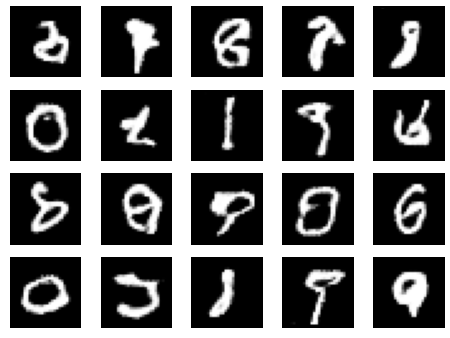

In [16]:
#print_digits(3, 8, True)
print_digits(4, 5)

